In [705]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import glob
import re
import datetime
from datetime import datetime
from numpy.random import seed 
from numpy.random import randn 
from numpy import mean
from numpy import std
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from numpy import exp
from sklearn.preprocessing import PowerTransformer
from matplotlib import pyplot

from numpy import isnan
from pandas import read_csv
from sklearn.impute import KNNImputer

import category_encoders as ce

from numpy import percentile

import scipy as sc
from pandas import read_csv


from sklearn.preprocessing import PowerTransformer

Funkcia, ktorá nahradí chýbajúce hodnoty v stĺpci column modusom (najviac vyskytovaný element). Funkcia využíva SimpleImputer.

In [706]:
def get_mode(data_frame, column):
    data = data_frame[column].values.reshape(-1, 1)
    imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
    data_frame[column] = imp.fit_transform(data)
    return data_frame

Funkcia, ktorá nahradí chýbajúce hodnoty v stĺpci column mediánom.

In [707]:
def get_median(data_frame, column):
    median = data_frame[column].median()
    data_frame[column].fillna(median, inplace = True)
    return data_frame

Funkcia, ktorá nahradí chýbajúce hodnoty v stĺpci column priemerom.

In [708]:
def get_mean(data_frame, column):
    mean = data_frame[column].mean()
    data_frame[column].fillna(mean, inplace = True)
    return data_frame

Naplnenie chýbajúcich hodnôt v stĺpci / stĺpcoch modusom.

In [709]:
 def fill_mode(data_frame, columns):
    for col in columns:
        data_frame = get_mode(data_frame, col)
    
    return data_frame

Naplnenie chýbajúcich hodnôt v stĺpci / stĺpcoch mediánom.

In [710]:
 def fill_median(data_frame, columns):
    for col in columns:
        data_frame = get_median(data_frame, col)
        
    return data_frame

Naplnenie chýbajúcich hodnôt v stĺpci / stĺpcoch priemerom.

In [711]:
 def fill_mean(data_frame, columns):
    for col in columns:
        data_frame = get_mean(data_frame, col)
        
    return data_frame

Pomocou tejto funkcie prevádzame adresu na numerickú hodnotu tak, že z danej adresy zistíme ZIP code / PSČ a uložíme ho do pôvodného záznamu

In [712]:
def get_zip(data_frame, column):
    for i in range(len(data_frame[column])):
        zipcode = str(data_frame[column][i])
        data_frame.loc[i, column] = zipcode[len(zipcode) - 5:len(zipcode)]
    data_frame[column] = data_frame[column].astype('int')
    return data_frame

Funkcia ráta vek respondentov v záznamoch. Našou analýzou sme zistili, že záznamy sú robené v rokoch 2018 a 2019. Z každého záznamu vezmeme atribút age a ak je hodnota tohto atribútu záporná alebo trojciferná (uvažujeme ako outliery), tak pomocou atribútu date-of-birth vypočítame nový vek. Ak nový vek zostane naďalej záporný alebo trojciferný, tak jednoducho tieto záznamy vymažeme. 

In [713]:
def calculate_age(data_frame, date_of_birth, age):
    for i in range(len(data_frame[date_of_birth])):
        curr_age = int(data_frame[age][i])
        
        if curr_age < 0 or curr_age > 99:
            year = data_frame[date_of_birth][i]
            year = year[:4]            
            new_age = 2019 - int(year)
            
            if new_age < 0 or new_age > 99:
                data_frame = data_frame.drop(i)
            else:
                data_frame.loc[i, age] = str(new_age)
                
    data_frame = data_frame.reset_index()
    data_frame = data_frame.drop('index', 1)        
    return data_frame

Funkcia, ktorá zjednotí duplikáty.

In [714]:
def unify_rows(data_frame):
    aggregation_functions = {}
    for col in data_frame.columns:
        aggregation_functions[col] = "first" 

    return data_frame.groupby(data_frame['name'], as_index=False).aggregate(aggregation_functions)

Pomocou tejto funkcie sme nahradzovali formáty hodnôt iba jednou hodnotou. Napr. hodnoty v atribúte pregnant (F, FALSE, f) sme nahradili hodnotou f.

In [715]:
def cleanse_some_values(data_frame, column, change_from, change_to):
    for i in range(len(change_from)):
        data_frame.loc[data_frame[column] == change_from[i], column] = change_to

V tejto funkcií sme pre každý atribút, kde sme uznali, že by bolo vhodné, zjednotili dáta. Vyuzili sme pipeline-u.

In [716]:
def unify_values(data_frame):
    unify_ppl = Pipeline([
                    ('1. step',  cleanse_some_values(data_frame, 'pregnant', ["F", "FALSE"], "f")),
                    ('2. step', cleanse_some_values(data_frame, 'pregnant', ["T", "TRUE"], "t")),

                    ('3. step', cleanse_some_values(data_frame, 'marital-status', [" Widowed", " Never-married", " Divorced"], "single")),
                    ('4. step',cleanse_some_values(data_frame, 'marital-status', [" Married-civ-spouse", " Separated", " Married-AF-spouse", " Married-spouse-absent"], "married")),

                    ('5. step', cleanse_some_values(data_frame, 'education', [" 1st-4th", " 5th-6th", " 7th-8th", " 9th", " 10th", " 11th", " 12th"], "Primary school")),
                    ('6. step', cleanse_some_values(data_frame, 'education', [" Bachelors", " Masters", " Doctorate"], "College")),
                    ('7. step', cleanse_some_values(data_frame, 'education', [" Assoc-voc", " HS-grad", " Prof-school", " Assoc-acdm", " Some-college"], "Highschool")),
                    ('8. step', cleanse_some_values(data_frame, 'education', [" Preschool"], "Preschool")),

                    ('9. step', cleanse_some_values(data_frame, 'workclass', [" Private"], "private")),
                    ('10. step', cleanse_some_values(data_frame, 'workclass', [" Self-emp-not-inc", " Self-emp-inc", "self-emp-inc", "self-emp-not-inc"], "self-emp")),
                    ('11. step', cleanse_some_values(data_frame, 'workclass', [" Never-worked", " Without-pay"], "not-working")),
                    ('12. step', cleanse_some_values(data_frame, 'workclass', [" Local-gov", "local-gov", " State-gov", "state-gov", " Federal-gov", "federal-gov"], "government")),
                    ('13. step', cleanse_some_values(data_frame, 'workclass', [" ?", "?"], np.nan))
                    ])
    unify_ppl = unify_ppl.fit(data_frame)
    data_frame = unify_ppl.transform(data_frame)
    return data_frame

Funkcia na zjednotenie formátu dátumov vo formáte YEAR-MONTH-DAY

In [717]:
def change_date_format(data_frame, column):
    for i in range(len(data_frame[column])):
        date_format = str(data_frame[column][i])
        date_format = date_format.replace('/', '-')
        if date_format[2] == '-' and len(date_format) < 10:
            temp_year = int(date_format[:2])
            if(temp_year <= 20):
                if(temp_year < 10):
                    year = '200'+str(temp_year)
                else:
                    year = '20'+str(temp_year)
            else:
                year = '19'+str(temp_year)
            data_frame.loc[i, column] = year+date_format[2:10]
        elif date_format[2] == '-' and len(date_format) == 10:
            day = date_format[:2]
            month = date_format[3:5]
            year = date_format[6:10]
            data_frame.loc[i, column] = year+'-'+month+'-'+day
        else:
            data_frame.loc[i, column] = date_format[:10]
    return data_frame

Funkcia zmaže outliery (v našom zadaní sme sa snažili outliery radšej nahrádzať ako mazať, preto nebolo potrebné túto funkciu použiť).

In [718]:
# def remove_outliers(data_frame, column):
#     a = data_frame[column]
#     lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
#     upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
#     outliers = a[(a > upper) | (a < lower)]
#     data_frame = data_frame.drop(outliers.index)
    
#     data_frame = data_frame.reset_index()
#     data_frame = data_frame.drop('index', 1)
    
#     return data_frame

Ďalšia funkcia na zmazanie outlierov (Interquartile Range Method).

In [719]:
# def remove_outliers_iqr(data_frame, column):
#     seed(1)
#     data = data_frame[column]
#     sns.distplot(data)

#     # calculate interquartile range
#     q25, q75 = percentile(data, 25), percentile(data, 75)
#     iqr = q75 - q25
#     print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr)) 

#     # calculate the outlier cutoff
#     cut_off = iqr * 1.5
#     lower, upper = q25 - cut_off, q75 + cut_off
#     print('cutoff=', cut_off, 'lower=', lower, 'upper=', upper)

#     # identify outliers
#     outliers = data[(data > upper) | (data < lower)]
#     print('Identified outliers: %d' % len(outliers))

#     # remove outliers
#     outliers_removed = [x for x in data if x >= lower and x <= upper] 
#     print('Non-outlier observations: %d' % len(outliers_removed))

#     sns.distplot(outliers_removed)
    
#     data_frame = data_frame.drop(outliers.index)
    
#     data_frame = data_frame.reset_index()
#     data_frame = data_frame.drop('index', 1)

#     return data_frame

Funkcia slúži na zmenu hodnoty "t" atribútu pregnant na "f" pre mužov (" Male" z atribútu sex).

In [720]:
def man_not_pregnant(data_frame, sex, pregnant):
    for i in range(len(data_frame[sex])):
        if(data_frame[sex][i] == " Male") and data_frame[pregnant][i] != "f":
            data_frame.loc[i, pregnant] = "f"
    return data_frame

Funkcia transformácie numerických dát, aby boli dáta lepšie distribuované. Zvolili sme metódu yeo-johnson, pretože pracuje nielen s pozitívnymi ale aj s negatívnymi hodnotami.

In [721]:
def transform_data(data_frame, columns):
    for col in columns:
        data = data_frame[col].values.reshape(-1, 1)
        power = PowerTransformer(method='yeo-johnson', standardize=True) 
        data_frame[col] = power.fit_transform(data)
        
    return data_frame

Funkcia mení kategorické dáta na numerické. Typ udáva ako formou prebieha kódovanie.

In [722]:
def encoding(data_frame, column, typ):
    data = data_frame[column]

    if typ == 0:
        ce_ordinal = ce.OneHotEncoder(cols=[column])
        data_frame[column] = ce_ordinal.fit_transform(data)
        
    elif typ == 1:
        ce_ordinal = ce.OrdinalEncoder(cols=[column])
        data_frame[column] = ce_ordinal.fit_transform(data)
    
    return data_frame

Funkcia mení kategorické dáta atribútu pregnant na numerické 0 - not pregnant, 1 - pregnant

In [723]:
def encode_pregnant(data_frame):
    cleanse_some_values(data_frame, 'pregnant', ["f"], 0)
    cleanse_some_values(data_frame, 'pregnant', ["t"], 1)
    data_frame['pregnant'] = data_frame['pregnant'].astype('int')
    return data_frame

Zakódovanie atribútov obsahujúcich kategorické hodnoty. 

In [724]:
def encode_objects(data_frame):
    data_frame = encoding(data_frame, 'sex', 0)
    data_frame = encoding(data_frame, 'race', 1)
    data_frame = encoding(data_frame, 'marital-status', 1)
    data_frame = encoding(data_frame, 'occupation', 1)
    data_frame = encode_pregnant(data_frame)
    data_frame = encoding(data_frame, 'relationship', 1)
    data_frame = encoding(data_frame, 'education', 1)
    data_frame = encoding(data_frame, 'income', 0)
    data_frame = encoding(data_frame, 'native-country', 1)
    data_frame = encoding(data_frame, 'workclass', 1)
    
    return data_frame

Funkcia na načítanie .csv súborov, ich spojenie podľa atribútov name a address a vyhodenie nepotrebných atribútov

In [725]:
def load_data():
    df_other_train = read_csv("data/other_train.csv")
    df_personal_train = read_csv("data/personal_train.csv")
    df_other_valid = read_csv("data/other_valid.csv")
    df_personal_valid = read_csv("data/personal_valid.csv")

    data_frame1 = pd.merge(df_personal_train, df_other_train, on=['name', 'address'])
    data_frame2 = pd.merge(df_other_valid, df_personal_valid, on=['name', 'address'])

    data_frame1 = unify_rows(data_frame1)

    data_frame = data_frame1.merge(data_frame2, how='outer')

    data_frame = data_frame.drop('Unnamed: 0_x', 1)
    data_frame = data_frame.drop('Unnamed: 0_y', 1)

    return data_frame

Funkia detailnejšie rozďeluje atribút medical-info na ďalšie atribúty (do viacero stĺpcov), ktoré sa potom pretypujú na typ float.

In [726]:
def split_medical_info(data_frame):
    medical_line = data_frame["medical_info"].str.replace(':', ',').str.replace("'", '').str.replace("{", '').str.replace("}", '')
    medical_elements = medical_line.str.split(",", -1, expand = True)

    diabetes_dataset = {}

    for index in range(0, medical_elements.shape[1]):
        i = medical_elements[0][0]
        if(index % 2 == 0):
            diabetes_dataset[medical_elements[index][0]] = medical_elements[index + 1]

    diabetes_dataset = pd.DataFrame(diabetes_dataset)
    data_frame = pd.concat([data_frame, diabetes_dataset.reindex(data_frame.index)], axis = 1)
    data_frame = data_frame.drop(columns = ['medical_info'])
    
    data_frame['mean_glucose'] = data_frame['mean_glucose'].astype(float)
    data_frame['std_glucose'] = data_frame['std_glucose'].astype(float)
    data_frame['kurtosis_glucose'] = data_frame['kurtosis_glucose'].astype(float)
    data_frame['skewness_glucose'] = data_frame['skewness_glucose'].astype(float)
    data_frame['mean_oxygen'] = data_frame['mean_oxygen'].astype(float)
    data_frame['std_oxygen'] = data_frame['std_oxygen'].astype(float)
    data_frame['kurtosis_oxygen'] = data_frame['kurtosis_oxygen'].astype(float)
    data_frame['skewness_oxygen'] = data_frame['skewness_oxygen'].astype(float)
    
    return data_frame

Funkcia nahradzuje outliery hodnotami z 5% alebo 95% kvartilu. Použili sme Interquartile Range Method.

In [727]:
def replace_outliers(data_frame, columns):
    
    for i in range(len(columns)):
#         sns.distplot(data_frame[columns[i]])

        # calculate interquartile range
        q5, q95 = percentile(data_frame[columns[i]], 5), percentile(data_frame[columns[i]], 95)
        iqr = q95 - q5
#         print('Percentiles: 5th=%.3f, 95th=%.3f, IQR=%.3f' % (q5, q95, iqr)) 

        # calculate the outlier cutoff
        cut_off = iqr * 1.5
        lower, upper = q5 - cut_off, q95 + cut_off
#         print('cutoff=', cut_off, 'lower=', lower + cut_off, 'upper=', upper - cut_off)

        # identify outliers
        outliers = data_frame[columns[i]][(data_frame[columns[i]] > upper) | (data_frame[columns[i]] < lower)]
#         print('Identified outliers: %d' % len(outliers))

        # data without outliers
        outliers_removed = data_frame[columns[i]][(data_frame[columns[i]] <= upper) & (data_frame[columns[i]] >= lower)]
#         print('Non-outlier observations: %d' % len(outliers_removed))


        for j, value in data_frame.iterrows():
                    if value[columns[i]] < lower:
                        data_frame.loc[j, columns[i]] = lower
                    elif value[columns[i]] > upper:
                        data_frame.loc[j, columns[i]] = upper

#         sns.distplot(data_frame[columns[i]])
    
    return data_frame

Kedže niektoré dáta nemôžu byť záporné (jedná sa o štandardnú odchýlku), tak záporné hodnoty tohto atribútu zmeníme na kladné.

In [728]:
def change_to_positive(data_frame, col):
    for i in range(len(data_frame[col])):
        data = data_frame[col][i]
        if data < 0:
            data_frame.loc[i, col] = abs(data)
    return data_frame

Využitie kNN imputácie na doplnenie chýbajúcich hodnôt.

In [729]:
def knn(data_frame, columns):
    # summarize total missing
    print("Missing: " + str(data_frame.isnull().sum().sum()))

#     temp = [col for col in data_frame.columns if data_frame[col].dtypes != 'O']

    temp = columns

    # define imputer
    imputer = KNNImputer()

    # fit on the dataset
    imputer.fit(data_frame[temp])

    # transform the dataset
    data_frame[temp] = imputer.transform(data_frame[temp])
    Xtrans = imputer.transform(data_frame[temp])

    # summarize total missing
    print("Missing: " + str(sum(isnan(Xtrans).flatten())))
    
    return data_frame

Execute funkcia je hlavná funkcia, ktorá spúšťa všetky ostatné.

In [730]:
def execute():
    df_merged = load_data()
    df_merged = split_medical_info(df_merged)
    df_merged = unify_values(df_merged)
    df_merged = change_date_format(df_merged,'date_of_birth')
    df_merged = change_to_positive(df_merged, 'std_glucose')
    
    df_merged = knn(df_merged, ['mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose', 
                            'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen'])
    df_merged = fill_median(df_merged, ['education-num', 'fnlwgt', 'hours-per-week'])
    df_merged = fill_mode(df_merged, ['class', 'race', 'marital-status', 'occupation', 'pregnant', 'relationship', 
                                  'education', 'income', 'native-country', 'workclass'])
    df_merged = fill_mean(df_merged, ['capital-gain', 'capital-loss'])
    df_merged = man_not_pregnant(df_merged, 'sex', 'pregnant')
    df_merged = get_zip(df_merged,'address')
    df_merged = df_merged.drop('name', 1)
    df_merged = calculate_age(df_merged, 'date_of_birth', 'age')
    df_merged = df_merged.drop('date_of_birth', 1)
    df_merged = encode_objects(df_merged)
    df_merged = replace_outliers(df_merged, ['capital-gain', 'capital-loss', 'skewness_oxygen'])
    df_merged = transform_data(df_merged, ['mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose', 
                            'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen'])
# # V analýze sme zistili, že v atribúte capital-loss sa všetky outliere nahradili rovnakou hodnotou, preto tento atribút 
# # nemá žiadnu výpovednú hodnotu a je vhodné ho zmazať (zakomentovať, ak atribút mazať nechceme).
    df_merged = df_merged.drop('capital-loss', 1)
    return df_merged

In [731]:
def sqrt_normalization(final_dataset,column):
    final_dataset[column] = np.sqrt(final_dataset[column])
    return final_dataset

Spustenie

In [732]:
df_merged = execute()

Missing: 1578
Missing: 0


c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
c:\users\matto\appdata\local\programs\python\python38\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [733]:
df_merged

,address,age,sex,race,marital-status,occupation,pregnant,education-num,relationship,capital-gain,...,hours-per-week,workclass,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
0,83114,37,1,1,1,1,0,9.0,1,0.0,...,40.0,1,0.968781,-0.055713,-1.513985,-0.813744,0.786762,0.889508,-0.713284,-0.767504
1,59124,58,1,1,1,1,0,9.0,1,0.0,...,38.0,1,-0.203531,-0.125013,0.039504,0.104418,-0.418416,-0.592412,0.228235,0.289294
2,17996,48,0,1,2,2,0,10.0,2,0.0,...,40.0,1,-0.435725,-1.191132,0.194571,0.873122,-1.398908,-1.186973,1.319330,1.255769
3,31095,45,0,1,2,3,0,4.0,2,0.0,...,40.0,2,-0.139780,-0.108897,-0.047748,-0.272835,-0.454595,-0.272475,0.250148,0.219212
4,73176,56,0,1,1,4,0,10.0,3,0.0,...,55.0,1,0.335702,0.115632,-0.766917,-1.444530,-1.276846,-1.294978,1.311728,1.305234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5287,81156,60,0,1,2,11,0,15.0,2,0.0,...,40.0,1,-1.885869,2.199242,1.738964,1.622907,1.679636,1.637153,-1.727173,-1.853399
5288,72779,43,0,1,2,4,0,9.0,2,0.0,...,40.0,1,0.157292,-0.223887,-0.078766,-0.376068,-1.248850,-1.112699,1.179821,1.149198
5289,73214,50,0,1,2,11,0,13.0,2,5178.0,...,40.0,3,2.271625,-0.663929,-1.808518,0.287042,-1.697400,-1.825011,2.032526,2.039874
5290,19977,49,1,1,1,7,0,9.0,6,0.0,...,40.0,1,0.398035,-1.014741,-0.069182,0.626696,-1.042387,-0.928198,0.963376,0.934239


In [734]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5292 entries, 0 to 5291
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   address           5292 non-null   int32  
 1   age               5292 non-null   int64  
 2   sex               5292 non-null   int64  
 3   race              5292 non-null   int32  
 4   marital-status    5292 non-null   int32  
 5   occupation        5292 non-null   int32  
 6   pregnant          5292 non-null   int32  
 7   education-num     5292 non-null   float64
 8   relationship      5292 non-null   int32  
 9   capital-gain      5292 non-null   float64
 10  education         5292 non-null   int32  
 11  fnlwgt            5292 non-null   float64
 12  class             5292 non-null   float64
 13  income            5292 non-null   int64  
 14  native-country    5292 non-null   int32  
 15  hours-per-week    5292 non-null   float64
 16  workclass         5292 non-null   int32  


In [735]:
df_merged.describe()

,address,age,sex,race,marital-status,occupation,pregnant,education-num,relationship,capital-gain,...,hours-per-week,workclass,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
count,5292.000000,5292.000000,5292.000000,5292.000000,5292.000000,5292.000000,5292.000000,5292.000000,5292.000000,5292.000000,...,5292.000000,5292.000000,5.292000e+03,5.292000e+03,5.292000e+03,5.292000e+03,5.292000e+03,5.292000e+03,5.292000e+03,5.292000e+03
mean,50332.301398,51.859033,0.332766,1.419123,1.506992,7.001323,0.016251,10.060091,2.702570,548.618466,...,40.249811,1.374528,-5.907763e-17,-4.011908e-15,1.074139e-17,-2.685347e-18,-3.893753e-17,-1.581669e-15,1.168126e-16,5.370693e-18
std,28650.965156,11.781341,0.471248,1.040149,0.499998,3.382082,0.126451,2.501215,1.436612,2098.157481,...,12.472580,0.704454,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00
min,527.000000,3.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,1.000000,-2.068046e+00,-2.632453e+00,-1.028392e+01,-6.096533e+00,-2.603378e+00,-2.558753e+00,-3.071474e+00,-2.071565e+00
25%,25245.000000,44.000000,0.000000,1.000000,1.000000,5.000000,0.000000,9.000000,2.000000,0.000000,...,40.000000,1.000000,-6.139666e-01,-4.978096e-01,-6.012086e-01,-6.946266e-01,-7.386587e-01,-8.047139e-01,-7.289569e-01,-7.765100e-01
50%,50631.500000,52.000000,0.000000,1.000000,2.000000,7.000000,0.000000,10.000000,2.000000,0.000000,...,40.000000,1.000000,1.716370e-01,-1.213077e-01,-1.764728e-01,-1.445682e-01,-2.494411e-01,-1.678359e-01,1.561976e-01,1.719501e-01
75%,75118.250000,60.000000,1.000000,1.000000,2.000000,10.000000,0.000000,12.000000,3.000000,0.000000,...,45.000000,1.000000,7.094252e-01,1.510767e-01,4.344608e-01,6.404726e-01,8.858042e-01,9.489198e-01,6.537159e-01,6.937514e-01
max,99943.000000,99.000000,1.000000,6.000000,2.000000,15.000000,1.000000,16.000000,6.000000,11625.000000,...,99.000000,4.000000,3.904769e+00,2.207145e+00,2.176502e+00,2.004975e+00,1.815126e+00,1.842087e+00,4.207569e+00,2.749699e+00


Vidíme, že atribút capital-loss má po nahradení outlierov iba jednú hodnotu, tak nám tento atribút je zbytočný.

In [736]:
# df_merged['capital-loss'].describe()

In [737]:
# df_merged['capital-loss'].unique()

## Párová analýza dát

Vykonanie príkazov na znovunačítanie dát do osobitného datasetu a ich následná úprava tak aby sme ich vedeli porovnať s očistenými dátami.

In [738]:
df_other_train_analysis = read_csv("data/other_train.csv")
df_personal_train_analysis = read_csv("data/personal_train.csv")

df_other_train_analysis.columns = df_other_train_analysis.columns.str.replace('-', '_')
df_personal_train_analysis.columns = df_personal_train_analysis.columns.str.replace('-', '_')

df_other_train_analysis = df_other_train_analysis.drop(columns = ['Unnamed: 0'])

medical_line = df_other_train_analysis["medical_info"].str.replace(':', ',').str.replace("'", '').str.replace("{", '').str.replace("}", '')
medical_elements = medical_line.str.split(",", -1, expand = True)

diabetes_dataset = {}

for index in range(0, medical_elements.shape[1]):
    i = medical_elements[0][0]
    if(index % 2 == 0):
        diabetes_dataset[medical_elements[index][0]] = medical_elements[index + 1]
        
diabetes_dataset = pd.DataFrame(diabetes_dataset)
        
diabetes_dataset = pd.concat([df_other_train_analysis, diabetes_dataset.reindex(df_other_train_analysis.index)], axis = 1)
diabetes_dataset = diabetes_dataset.drop(columns = ['medical_info'])

diabetes_dataset['mean_glucose'] = diabetes_dataset['mean_glucose'].astype(float)
diabetes_dataset['std_glucose'] = diabetes_dataset['std_glucose'].astype(float)
diabetes_dataset['kurtosis_glucose'] = diabetes_dataset['kurtosis_glucose'].astype(float)
diabetes_dataset['skewness_glucose'] = diabetes_dataset['skewness_glucose'].astype(float)
diabetes_dataset['mean_oxygen'] = diabetes_dataset['mean_oxygen'].astype(float)
diabetes_dataset['std_oxygen'] = diabetes_dataset['std_oxygen'].astype(float)
diabetes_dataset['kurtosis_oxygen'] = diabetes_dataset['kurtosis_oxygen'].astype(float)
diabetes_dataset['skewness_oxygen'] = diabetes_dataset['skewness_oxygen'].astype(float)

Vykreslenie nových grafov. Keďže sme menili všetky atribúty na číselné, vieme porovnať každý atribút s každým. Toto zobrazenie má teda veľkosť 25*25 a zobrazuje závislosti medzi atribútmi. Pri niektorých atribútoch sa nám zvýšila závislosť a pri niektorých klesla.

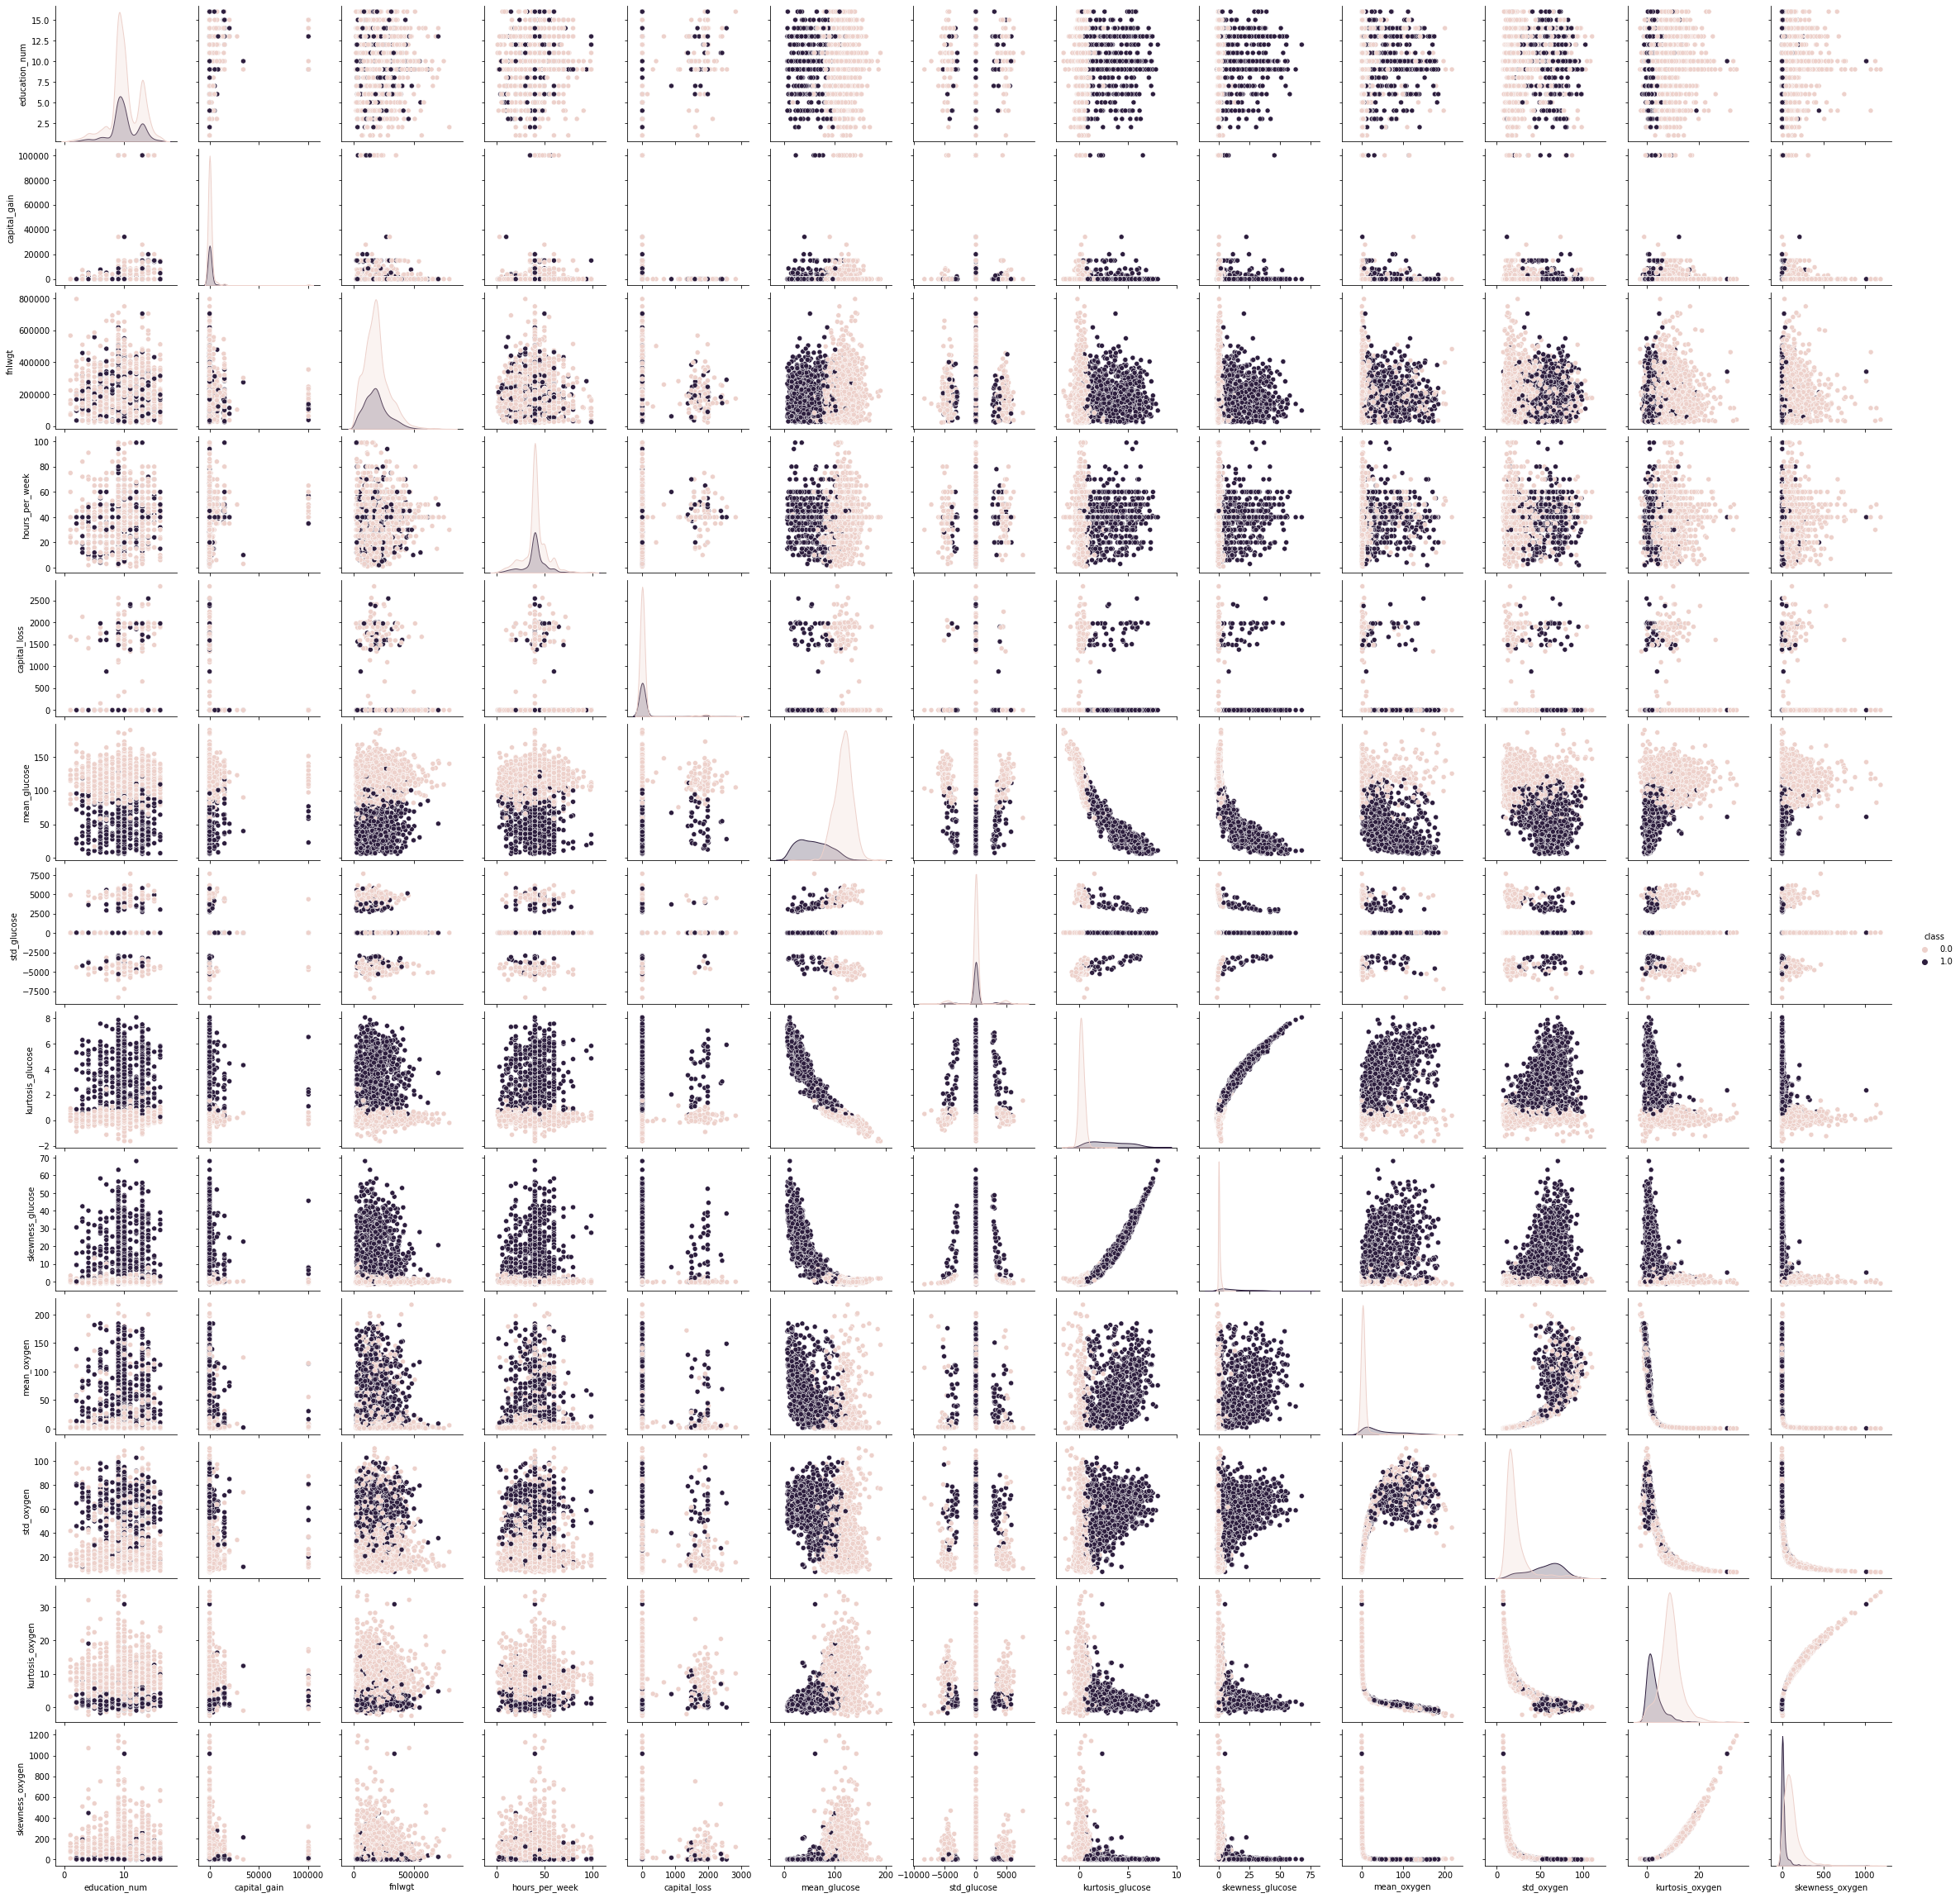

In [739]:
# vykonavanie trva dost dlho, v pripade potreby odkomentovat
sns.pairplot(diabetes_dataset, hue = "class")

Zobrazenie atribútov mean_oxygen a std_oxygen v pôvodnom datasete. Aj podľa korelácie vieme povedať, že môžu byť čiastočne závislé. Podľa grafu to už nemusí byť úplne jasné.

Pearson correlation: 0.800


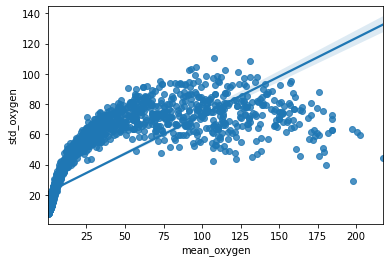

In [740]:
sns.regplot(x = "mean_oxygen", y = "std_oxygen", data = diabetes_dataset)
print("Pearson correlation: %.3f" % diabetes_dataset.mean_oxygen.corr(diabetes_dataset.std_oxygen))

Zobrazenie atribútov mean_oxygen a std_oxygen v novom datasete. Po úprave dát sme dostali prakticky rovnú priamku a aj korelácia sa omnoho zvýšila, takže s istotou vieme povedať, že atribúty sú závislé.

Pearson correlation: 0.974


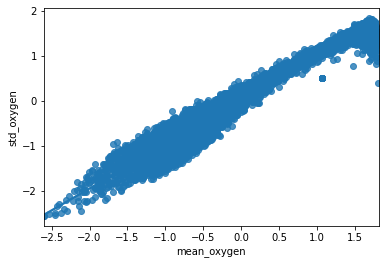

In [741]:
sns.regplot(x = "mean_oxygen", y = "std_oxygen", data = df_merged)
print("Pearson correlation: %.3f" % df_merged.mean_oxygen.corr(df_merged.std_oxygen))

# diabetes_dataset
# df_merged

Zobrazenie atribútov mean_oxygen a skewness_oxygen v pôvodnom datasete. Na prvý pohľad sa zdá, že atribúty nebudú vôbec závislé.

Pearson correlation: -0.396


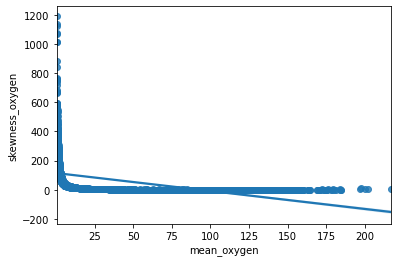

In [742]:
sns.regplot(x = "mean_oxygen", y = "skewness_oxygen", data = diabetes_dataset)
print("Pearson correlation: %.3f" % diabetes_dataset.mean_oxygen.corr(diabetes_dataset.skewness_oxygen))

Zobrazenie atribútov mean_oxygen a skewness_oxygen v novom datasete. Opäť sme dostali po úprave tovnú priamku. Aj napriek tomu, že sme najskôr považovali atribúry za úplne nezávislé tak po úprave je korelácia takmer rovná 1. Atribúty sú teda na sebe určite závislé.

Pearson correlation: -0.984


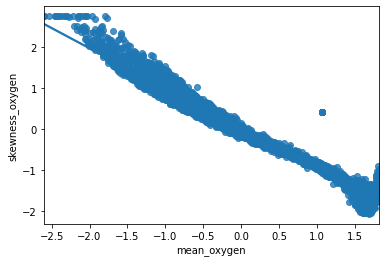

In [743]:
sns.regplot(x = "mean_oxygen", y = "skewness_oxygen", data = df_merged)
print("Pearson correlation: %.3f" % df_merged.mean_oxygen.corr(df_merged.skewness_oxygen))

Zobrazenie atribútov kurtosis_glucose a skewness_glucose v pôvodnom datasete. Mali vysokú závislosť.

Pearson correlation: 0.962


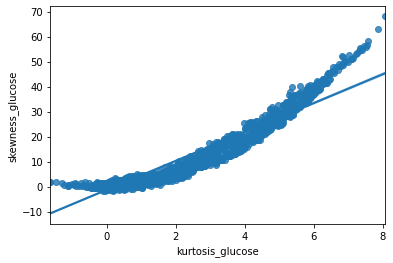

In [744]:
sns.regplot(x = "kurtosis_glucose", y = "skewness_glucose", data = diabetes_dataset)
print("Pearson correlation: %.3f" % diabetes_dataset.kurtosis_glucose.corr(diabetes_dataset.skewness_glucose))

Zobrazenie atribútov kurtosis_glucose a skewness_glucose v novom datasete. Súdiac podľa korelácie, atribúty majú stále nejakú závislosť. V tomto prípade nám ale závislosť po úprave celkom klesla.

Pearson correlation: 0.769


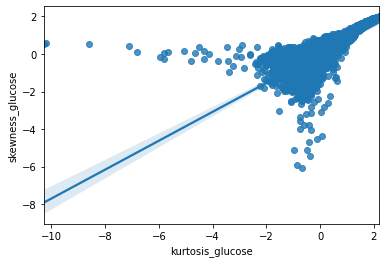

In [745]:
sns.regplot(x = "kurtosis_glucose", y = "skewness_glucose", data = df_merged)
print("Pearson correlation: %.3f" % df_merged.kurtosis_glucose.corr(df_merged.skewness_glucose))

Zobrazenie atribútov kurtosis_oxygen a kurtosis_oxygen v pôvodnom datasete. Opäť boli závislé.

Pearson correlation: 0.917


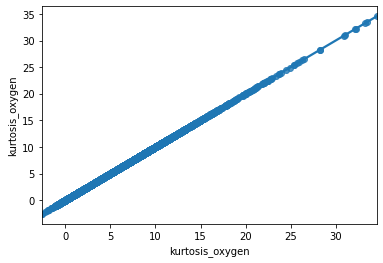

In [746]:
sns.regplot(x = "kurtosis_oxygen", y = "kurtosis_oxygen", data = diabetes_dataset)
print("Pearson correlation: %.3f" % diabetes_dataset.kurtosis_oxygen.corr(diabetes_dataset.skewness_oxygen))

Zobrazenie atribútov kurtosis_oxygen a kurtosis_oxygen v novom datasete. Vydíme, že korelácia je ešte vyššia. Na tomto grafe možno pozorovať to, že jeho začiatok a koniec neležia na priamke ako zvyšok dát. To je spôsobené tým, že sme hodnoty, ktoré boli identifikované ako outliery nahradili hraničnými hodnotami.

Pearson correlation: 0.989


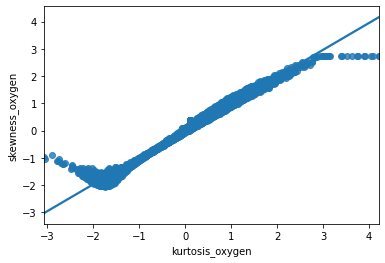

In [747]:
sns.regplot(x = "kurtosis_oxygen", y = "skewness_oxygen", data = df_merged)
print("Pearson correlation: %.3f" % df_merged.kurtosis_oxygen.corr(df_merged.skewness_oxygen))

Na grafe nižšie je pekne vidno, že viacero hodnôt bolo nahradených hraničnými hodnotami, konkrétne na tomto grafe je to hodnota okolo čísla 2 pre atribút std_glucose.

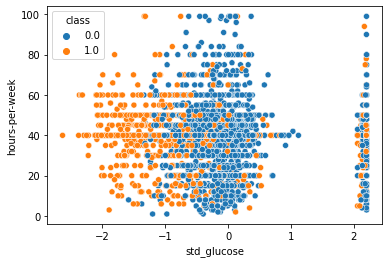

In [748]:
sns.scatterplot(x = "std_glucose", y = "hours-per-week", hue = "class", data = df_merged)

Na tomoto grafe sa dá pozorovať doplnenie chýbajúcich hodnôt medánom. Doplnený je atribút hours-per-week a jedná sa o hodnotu okolo 40.

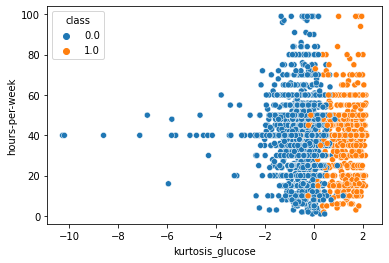

In [749]:
sns.scatterplot(x = "kurtosis_glucose", y = "hours-per-week", hue = "class", data = df_merged)

Vyššie sme vyberali dáta na analýzu podľa grafov a ich vizualizácie. Podľa heatmapy môžeme vidieť závislosti aj atribútov, ktoré sme predtým nevideli. Dosiahli sme to tým že sme všetky atribúty zmenili na číselné. Vykreslíme si heatmapu a presne vidíme podľa farby, ktoré atribúty sú závislé. Čím je farba svetlejšia, alebo tmavšia, tý väčšia závislosť. Atribúty, ktoré majú farbu okolo nuly čiže červenú/ružovú/tmavo oranžovú/jemne fialovú sú nezávislé.

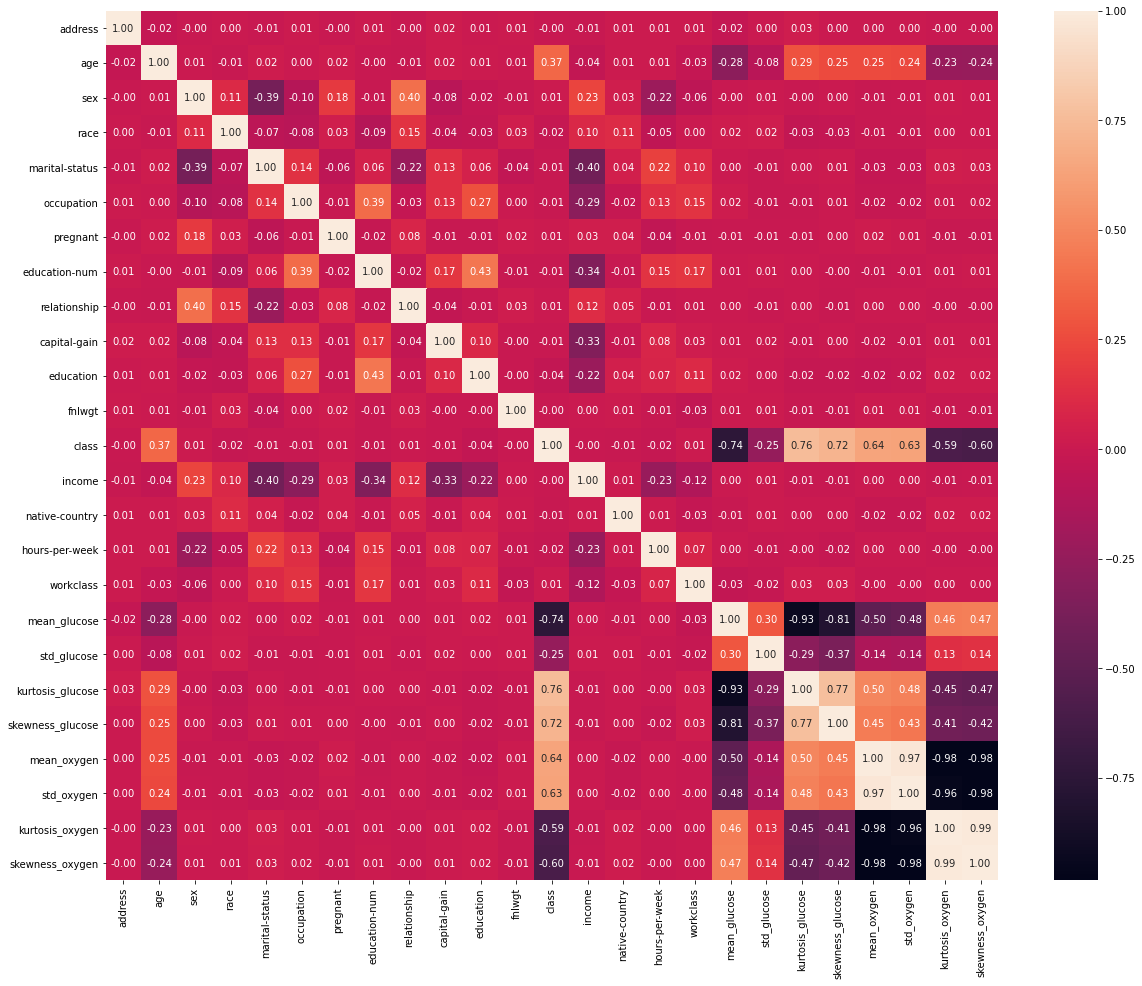

In [750]:
fig, ax = plt.subplots(figsize = (20, 16))
sns.heatmap(df_merged.corr(), ax = ax, annot = True, fmt = ".2f")

Zobrazíme si describe pôvodného datasetu.

In [751]:
diabetes_dataset.describe()

,education_num,capital_gain,fnlwgt,class,hours_per_week,capital_loss,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
count,3961.000000,3969.000000,3968.000000,3960.000000,3966.000000,3973.000000,3966.000000,3569.000000,3966.000000,3966.000000,3966.000000,3966.000000,3966.000000,3966.000000
mean,10.052764,1134.530108,189963.996976,0.256313,40.203984,72.926252,101.216969,52.162980,0.952093,4.217941,18.536444,31.175025,7.405038,91.150137
std,2.520019,8067.028170,102327.438172,0.436652,12.317838,360.910859,33.561759,1440.724427,1.609773,9.665886,34.926620,22.260524,4.811556,108.499977
min,1.000000,0.000000,20308.000000,0.000000,1.000000,0.000000,6.187500,-8305.388133,-1.641515,-1.755332,0.213211,7.370432,-2.597872,-1.976976
25%,9.000000,0.000000,119475.250000,0.000000,40.000000,0.000000,87.558594,39.395746,0.072387,-0.118819,2.065426,15.040901,3.626800,12.737910
50%,10.000000,0.000000,180585.500000,0.000000,40.000000,0.000000,110.613281,46.024068,0.311415,0.377633,3.238294,20.595058,7.779976,68.348245
75%,12.000000,0.000000,236173.000000,1.000000,45.000000,0.000000,124.130859,51.117280,0.781897,2.092365,12.686873,43.369641,10.259050,126.983317
max,16.000000,99999.000000,795830.000000,1.000000,99.000000,2824.000000,189.734375,7678.445784,8.069522,68.101622,217.371238,110.642211,34.539844,1191.000837


Zobrazíme si describe nového datasetu. Tu presne vidno aké zmeny nastali oproti pôvodnému datasetu.

In [752]:
df_merged.describe()

,address,age,sex,race,marital-status,occupation,pregnant,education-num,relationship,capital-gain,...,hours-per-week,workclass,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen
count,5292.000000,5292.000000,5292.000000,5292.000000,5292.000000,5292.000000,5292.000000,5292.000000,5292.000000,5292.000000,...,5292.000000,5292.000000,5.292000e+03,5.292000e+03,5.292000e+03,5.292000e+03,5.292000e+03,5.292000e+03,5.292000e+03,5.292000e+03
mean,50332.301398,51.859033,0.332766,1.419123,1.506992,7.001323,0.016251,10.060091,2.702570,548.618466,...,40.249811,1.374528,-5.907763e-17,-4.011908e-15,1.074139e-17,-2.685347e-18,-3.893753e-17,-1.581669e-15,1.168126e-16,5.370693e-18
std,28650.965156,11.781341,0.471248,1.040149,0.499998,3.382082,0.126451,2.501215,1.436612,2098.157481,...,12.472580,0.704454,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00,1.000094e+00
min,527.000000,3.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,1.000000,-2.068046e+00,-2.632453e+00,-1.028392e+01,-6.096533e+00,-2.603378e+00,-2.558753e+00,-3.071474e+00,-2.071565e+00
25%,25245.000000,44.000000,0.000000,1.000000,1.000000,5.000000,0.000000,9.000000,2.000000,0.000000,...,40.000000,1.000000,-6.139666e-01,-4.978096e-01,-6.012086e-01,-6.946266e-01,-7.386587e-01,-8.047139e-01,-7.289569e-01,-7.765100e-01
50%,50631.500000,52.000000,0.000000,1.000000,2.000000,7.000000,0.000000,10.000000,2.000000,0.000000,...,40.000000,1.000000,1.716370e-01,-1.213077e-01,-1.764728e-01,-1.445682e-01,-2.494411e-01,-1.678359e-01,1.561976e-01,1.719501e-01
75%,75118.250000,60.000000,1.000000,1.000000,2.000000,10.000000,0.000000,12.000000,3.000000,0.000000,...,45.000000,1.000000,7.094252e-01,1.510767e-01,4.344608e-01,6.404726e-01,8.858042e-01,9.489198e-01,6.537159e-01,6.937514e-01
max,99943.000000,99.000000,1.000000,6.000000,2.000000,15.000000,1.000000,16.000000,6.000000,11625.000000,...,99.000000,4.000000,3.904769e+00,2.207145e+00,2.176502e+00,2.004975e+00,1.815126e+00,1.842087e+00,4.207569e+00,2.749699e+00


In [753]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5292 entries, 0 to 5291
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   address           5292 non-null   int32  
 1   age               5292 non-null   int64  
 2   sex               5292 non-null   int64  
 3   race              5292 non-null   int32  
 4   marital-status    5292 non-null   int32  
 5   occupation        5292 non-null   int32  
 6   pregnant          5292 non-null   int32  
 7   education-num     5292 non-null   float64
 8   relationship      5292 non-null   int32  
 9   capital-gain      5292 non-null   float64
 10  education         5292 non-null   int32  
 11  fnlwgt            5292 non-null   float64
 12  class             5292 non-null   float64
 13  income            5292 non-null   int64  
 14  native-country    5292 non-null   int32  
 15  hours-per-week    5292 non-null   float64
 16  workclass         5292 non-null   int32  
